In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Housing.csv')

In [3]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [5]:
df['mainroad']=df['mainroad'].map({'yes':1, 'no':0})
df['guestroom']=df['guestroom'].map({'yes':1, 'no':0})
df['basement']=df['basement'].map({'yes':1,'no':0})
df['hotwaterheating']=df['hotwaterheating'].map({'yes':1, 'no':0})
df['airconditioning']=df['airconditioning'].map({'yes':1,'no':0})
df['prefarea'] = df['prefarea'].map({'yes':1, 'no':0})

In [6]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


In [24]:
status = pd.get_dummies(df['furnishingstatus'], drop_first=True)
df = pd.concat([df,status],axis=1)
df.drop('furnishingstatus',axis=1, inplace=True)
df['areaperbedroom'] = df['area']/df['bedrooms']
df['bbratio'] = df['bathrooms']/df['bathrooms']

In [25]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,areaperbedroom,bbratio,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1855.0,1.0,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,2240.0,1.0,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,3320.0,1.0,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1875.0,1.0,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1855.0,1.0,0,0


In [26]:
df.columns

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'areaperbedroom', 'bbratio', 'semi-furnished',
       'unfurnished'],
      dtype='object')

In [28]:
from sklearn.model_selection import train_test_split
X = df[['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'areaperbedroom', 'bbratio', 'semi-furnished',
       'unfurnished']]
Y = df['price']

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size = 0.7, random_state=100)

In [36]:
def vif_cal(input_data, dependent_col):
    vif_df = pd.DataFrame(columns = ['Var','Vif'])
    X_vars = input_data.drop([dependent_col],axis=1)
    xvar_names = X_vars.columns
    for i in range(0,xvar_names.shape[0]):
        Y = X_vars[xvar_names[i]]
        X = X_vars[xvar_names.drop(xvar_names[i])]
        rsq = sm.OLS(Y,X).fit().rsquared
        vif = round(1/(1-rsq),2)
        vif_df.loc[i] = [xvar_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis=0, ascending=False, inplace= False)

In [30]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
rfe = RFE(lr, 9)
rfe = rfe.fit(X_train, Y_train)
print(rfe.support_)
print(rfe.ranking_)

[False False  True  True  True  True False  True  True  True  True False
 False False  True]
[6 3 1 1 1 1 2 1 1 1 1 5 7 4 1]


In [31]:
col = X_train.columns[rfe.support_]

In [32]:
X_train_rfe = X_train[col]
import statsmodels.api as sm
X_train_rfe = sm.add_constant(X_train_rfe)
lr = sm.OLS(Y_train, X_train_rfe).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     68.14
Date:                Sun, 03 May 2020   Prob (F-statistic):           3.75e-73
Time:                        01:12:57   Log-Likelihood:                -5846.2
No. Observations:                 381   AIC:                         1.171e+04
Df Residuals:                     371   BIC:                         1.175e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            9.296e+05   2.38e+05     

In [37]:
vif_cal(input_data=df.drop(['area','bedrooms','stories','basement', 'semi-furnished', 'areaperbedroom'], axis=1), dependent_col='price')

,Var,Vif
7,bbratio,15.01
4,airconditioning,1.11
5,parking,1.11
1,mainroad,1.10
0,bathrooms,1.09
6,prefarea,1.08
2,guestroom,1.06
8,unfurnished,1.06
3,hotwaterheating,1.04


In [39]:
X_test_rfe = X_test[col]
X_test_rfe = sm.add_constant(X_test_rfe)
Y_pred = lr.predict(X_test_rfe)

Text(0.5, 0.98, 'Actula vs Prediction')

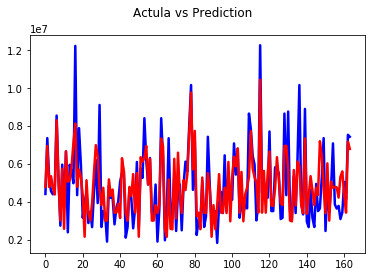

In [61]:
index = [x for x in range(0,Y_pred.shape[0])]
plt.figure()
plt.plot(index, Y_test,color='blue', linewidth=2.5, linestyle='-')
plt.plot(index, Y_pred, color='red', linewidth=2.5, linestyle='-')
plt.suptitle('Actula vs Prediction')